# CSE 6240 Web Search and Text Mining
## Homework 4: Node2vec and embeddings [8 points]

This homework asks you to implement node2vec and use generated embeddings for downstream experiments.

Please read the following statement and abide by it. Please run the following cell substituting your student and user names to agree. 

In [1]:
def author_honor_code (student_name='Yeojin Chang', user_name='ychang354'):
  print (f'I, {student_name} ({user_name}), state that I performed the tasks in this assignment following the Georgia Tech honor code(https://osi.gatech.edu/content/honor-code).')

# print the honor code before submission (substitute your name and username)
author_honor_code ()

I, Yeojin Chang (ychang354), state that I performed the tasks in this assignment following the Georgia Tech honor code(https://osi.gatech.edu/content/honor-code).


# Part 1: SVD and Node2vec [4.5 points]

Lets download the HW4 files locally in the Colab environment.When you run the following cell, 4 files will be downloaded.
After this, we set the working directory to the Colab folder where these files are folder so that that we are able to access the datafiles with the help of relative path.

In [2]:
!wget https://www.dropbox.com/s/fnneeb8apb28wrd/HW4_files.zip?dl=1 -O output.zip
! unzip output.zip
! rm output.zip
path = './'
%cd $path

--2023-03-08 03:25:54--  https://www.dropbox.com/s/fnneeb8apb28wrd/HW4_files.zip?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.4.18, 2620:100:6018:18::a27d:312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.4.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/dl/fnneeb8apb28wrd/HW4_files.zip [following]
--2023-03-08 03:25:54--  https://www.dropbox.com/s/dl/fnneeb8apb28wrd/HW4_files.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucbab73d5b3b1ceef783178b2ae6.dl.dropboxusercontent.com/cd/0/get/B3068LqCX3RfcEfKWX7sJ-ydqUmBEDnoien2s5N9d2SCl5OrkWGFlKeJ7EalLaz-DuQzB-ZrJx06l61qjEL5EiemE-byF7xkL9Swb7EB3o1x3XGpFK_ubCflC2SFSxGQLDt22IQlps7fGrmfl2tjL9JzG1PgrDgiI2CfJVTzRbEDSgPE4mzz9DPNdTyMqsRY7k4/file?dl=1# [following]
--2023-03-08 03:25:55--  https://ucbab73d5b3b1ceef783178b2ae6.dl.dropboxusercontent.com/cd/0/get/B3068LqCX3RfcEfKWX7sJ-ydqUmBEDnoien2s5N9d2SCl5OrkWGFlK

## Note:
It is important for you to understand what node2vec is before you start this part, refer to the slides and make sure you understand all key concepts. This part will ask you to generate embeddings using SVD and node2vec.

In [3]:
!pip install networkx==3.0
!pip install scipy==1.8.0
!pip install gensim==3.6.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 MB 9.3 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.10.1
    Uninstalling scipy-1.10.1:
      Successfully uninstalled scipy-1.10.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
# !pip install networkx==3.0
# !pip install scipy
import numpy as np
import networkx as nx
from collections import defaultdict
import scipy.io
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from scipy.sparse.linalg import svds
from copy import deepcopy
from collections import Counter

In [5]:
import gensim
print(gensim.__version__) # 3.6.0
print(nx.__version__) # 3.0
print(scipy.__version__) # 1.8.0

3.6.0
3.0
1.8.0


In [6]:
# Input parameters for Part 1. 
# Do not modify this. There is a -5 point penalty if you modify this block of code.

input='karate.edgelist' # Path for input edgelist

p=0.25 # Return parameter

q=0.25 # In-out parameter

walks=10 # Walks per node

length=80 # Length of each walk

d=16 # Dimension of output embeddings

window=10 # Window size for word2vec

workers=1 # Number of workers to assign for random walk and word2vec

directed=True # Specify if graph is directed.

In [7]:
def read_graph(input_path, directed=True): 
    """
    Do not modify this function. There is a -5 point penalty if you modify this function.
    
    This function will be called later. Check below to see how this function is called.
    Inputs: 
    input_path: file path
    directed: True if you want a directed graph, False if you want a undirected graph

    Return:
    G: Graph(nx.graph)
    labels: Label of each node (will be used in part 3 (node classification))
    probs: Initial transition probabilities
    """
    type=float('inf')
    if(input_path.split('.')[-1] == 'edgelist'):
        G = nx.read_edgelist(input_path, nodetype=int, data=(('weight',float),), create_using=nx.DiGraph())
        type=0
    elif(input_path.split('.')[-1] == 'mat'):  # used in part 3
        edges = []
        G = nx.Graph()
        mat = scipy.io.loadmat(input_path)
        nodes = mat['network'].tolil()
        labels = mat['group'].tocoo()
        
        for start_node,end_nodes in enumerate(nodes.rows, start=0):
            for end_node in end_nodes:
                edges.append((start_node,end_node))
        
        G.add_edges_from(edges)
        type=1
    
    G.name = input_path
    if not directed:
        G = G.to_undirected()
        
    probs = defaultdict(dict)
    for node in G.nodes():
        probs[str(node)] = dict()
        
    if type:
      return G, labels, probs
    else:
      return G, probs

### Part 1.1 Use SVD to generate embeddings

High level ideas of SVD can be found here: https://towardsdatascience.com/art-of-vector-representation-of-words-5e85c59fee5

In [8]:
def SVD_embedding(G, size=16):
    """
    Use SVD to generate embeddings. 
    Inputs: 
    G: nx.graph
    size: output_dimension of SVD

    Steps to follow to generate SVD embeddings: 
    1. Generate adjacency matrix of G (nx.adjacency_matrix might be helpful)
    2. Use the imported function svds to generate U, Sigma, V to compute the k largest singular values (k=size). 
       Use the all ones vector as the starting vector for the iteration and random state to be 42.
    3. Embeddings will then be U*np.sqrt(sigma) + V.T*np.sqrt(sigma)     (Use np.matmul for matrix multiplication)
    4. Reorganize embeddings to `embeddings_dict`. The format of embeddings_dict is as follows: 
      embeddings_dict is a dictionary, where 
      the key is str(id of the node) and 
      the corresponding value is embedding of the node. The format of the embedding is a list. 

    Return:
    embeddings_dict 
    """
    embeddings_dict=None
    ## write your code below [1 point]##
    adj_G = nx.adjacency_matrix(G, dtype='float')
    N = adj_G.shape[0]
    u, sigma, v = svds(A=adj_G, k=size, v0=np.full(N, float(1.0)), random_state=42)
    s = np.zeros((len(sigma), len(sigma)), float)
    np.fill_diagonal(s, val=sigma)

    embeddings = u@np.sqrt(s) + v.T@np.sqrt(s)
    embeddings_dict = {str(i):embeddings[i-1] for i in G.nodes}
    #####################################
    return embeddings_dict

In [9]:
# read graph
Graph, init_probabilities = read_graph(input, directed)
# call SVD_embedding
svd_embeddings=SVD_embedding(Graph,d)

In [10]:
# This is for sanity check. The output of this line should be True if your code is correct.
print(np.allclose([abs(x) for x in svd_embeddings['1']],[0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
                                                    0.08320129,  0.1800766 ,  0.16453194,  0.30643391,  0.18557105,
                                                    0.36963018, 0.02398039,  0.18324411, 0.60218272, 1.59563477,
                                                    0.68135488],atol=0.001))

True


### Part 1.2 Use Node2vec to generate embeddings

Let $c_i$ be the $i$th node in the walk, the definition of normalized probability is given as:

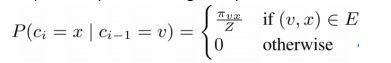

Where $x$ and $v$ are nodes, $π_{vx}$ is unnormalized transition probability between node $v$ and $x$, and $Z$ is a normalizing constant. $π_{vx}=\alpha_{pq}(v,x) \times W_{vx}$.

$\alpha_{pq}(v,x)=\frac{1}{p},$ if $d_{vx}=0$

$\alpha_{pq}(v,x)=1,$ if $d_{vx}=1$

$\alpha_{pq}(v,x)=\frac{1}{q},$ if $d_{vx}=2$

where $W_{vx}$ is the weight of the edge from node $v$ to node $x$. We will consider $W_{vx}=1$ in this homework for all edges (v,x). 

Thus, $π_{vx} = \alpha_{pq}(v,x)$ in our setting.  $\alpha_{pq}(v,x)$ is the search bias between node $v$ and $x$, $p$ is the return parameter and $q$ is in-out parameter. $d_{vx}$ is the shortest distance from node $v$ to node $x$, the value of $d_{vx}$ is limited to [0,1,2]. 



Check the node representation learning slides and lecture from the class. 

In [11]:
def compute_transition_probs(G, probs, p, q):
    """
    Inputs: 
    G: nx.graph
    probs: this is a dictionary of transition scores that you will fill. 
    p: the return parameter
    q: the in-out parameter
    
    Follow the formula above to create transition_probs. 

    Steps to follow: 
    1. Iterate over all nodes s in G.
    2. In each iteration, iterate over all neighbors c of node s.
    3. For every neighbor d of node c, calculate the probability of a random walker
       visiting node d from node c if the random walker was on node s in the previous step. 
    4. Store the probability values in transition_probs. 

    Return: 
    transition_probs: This is a dictionary of transition probabilities during the random walk. 
    This is a nested dictionary.  
    transition_probs[s][c] = a list of normalized probability scores of visiting node d from node s via node c. 
    
    The format of transition_probs is given after this cell. 
    """
    transition_probs = deepcopy(probs)
    ## write your code below [1 point]##

    shortest_distances = dict(nx.all_pairs_shortest_path_length(G))
    for s in G.nodes():
      transition_probs[str(s)] = {}
      for c in G.neighbors(s):
        a_list = []
        for d in G.neighbors(c):
          dist = shortest_distances[s][d]
          if dist == 0: 
            alpha = 1/p
          elif dist == 1: 
            alpha = 1.0
          elif dist == 2: 
            alpha = 1/q
          a_list.append(alpha)
        a_list = np.array(a_list)/np.sum(a_list)
        transition_probs[str(s)][str(c)] = a_list
        
    ##########################
    return transition_probs

In [12]:
Graph, probs = read_graph(input, directed)
tp = compute_transition_probs(Graph, probs, p, q)

The format of transition_probs after you called compute_transition_probs should be:

trans_probs.png

In [13]:
def generate_walks(G, transition_probs, walks_per_node, length):
    """
    Generate biased random walks based on probabilities you computed in the function compute_transition_probs. 
    Inputs:
    G: nx.graph
    transition_probs: Dictionary of transition probabilities during the random walk 
    walks_per_node: Length of walks for each node in graph G
    length: Length of each walk

    Steps to follow: 
    1. Iterate over all nodes s in G. 
    2. In every random walk starting from node s, do the following:
       2.1 For the first step of the walk, directly call np.random.choice over all the neighbors of node s (without using p). This will be the next node in the current random walk.
       2.2 In the next steps of the walk, use transition_probs to find the next node in the random walk. 
       Hint: transition_probs[walk[-2]][walk[-1]] will be the transition probabilities of taking the next step in the random walk. 
       2.3 Store all the nodes of the random walk in a list. Store nodes in str format, not int format. 
    3. Store all the random walks in a list. 
    4. Shuffle the list of all random walks. Use np.random.shuffle. This is to ensure there is no bias because of the node ordering. Do not shuffle the nodes within a random walk. 
    5. Return the list of all random walks. 

    Return:
    walks(list of list of str: [[str],[str,str...]]): Simulated walks from each node
    """
    np.random.seed(0)
    walks = []
    ## write code below [1.5 points]##

    for s in G.nodes():
      for walk_per_node in range(walks_per_node):
        curr_walk = []
        curr_walk.append(str(s))
        
        if len(list(G.neighbors(s))) == 0:
          continue
        
        neighbors = list(G.neighbors(s))
        curr_walk.append(str(np.random.choice(neighbors)))

        for step in range(length-2):
          neighbors = list(G.neighbors(int(curr_walk[-1])))
          if len(neighbors) == 0:
            break
          prev2_node = curr_walk[-2]
          prev1_node = curr_walk[-1]
          tp = transition_probs[prev2_node][prev1_node]
          curr_walk.append(str(np.random.choice(neighbors, size=1, p=tp)[0]))
        
        walks.append(curr_walk)

    np.random.shuffle(walks)
    ################################
    return walks

In [14]:
def generate_embeddings(walks, dimensions, window_size, num_workers, p, q):
    """
    Do not modify this function. There is a -5 point penalty if you modify this function.

    Here we use word2vec code to generate node embeddings from the random walks. 
    Please refer to https://radimrehurek.com/gensim/models/word2vec.html for more information about word2vec.
    
    walks: Simulated random walks
    dimensions: Output dimension of node embeddings
    window_size: Window size for word2vec
    num_workers: Number of workers to assign for random walk and word2vec
    p: Return parameter
    q: In out parameter 
    
    Return:
    model: the learned word2vec model
    embeddings: embeddings of all nodes generated using the word2vec model
    """
    model=None
    embeddings=None
    model = Word2Vec(walks, size=dimensions, window=window_size, min_count=0, sg=1, workers=num_workers,seed=0)
    embeddings = model.wv

    return model, embeddings

In [15]:
def Node2vec(input, directed, p, q, walks, length, workers, d, window):
  """
  Generate embeddings for node2vec using the above functions you just implemented. 
  Inputs:
  input: Path for input
  directed: True if you want a directed graph, False if you want a undirected graph
  p: Return parameter
  q: In out parameter
  walks: Length of walks for each node in graph G
  length: Length of each walk
  workers: Number of workers to assign for random walk and word2vec
  d: Output dimension of node embeddings
  window: Window size for word2vec

  Steps to follow:
  1. Call compute_transition_probs.
  2. Call generate_walks.
  3. Call generate_embeddings. 

  Return:
  walk: simulated walks from each node
  model: word2vec model
  node2vec_embeddings: embeddings generated from the model
  """
  try:
    Graph, probs = read_graph(input, directed)
  except:
    Graph, _, probs = read_graph(input, directed)
  model=None
  node2vec_embeddings=None
  ## write your code below [1 points]##

  transition_probs = compute_transition_probs(Graph, {}, p, q)
  walk = generate_walks(Graph, transition_probs, walks, length)
  model, node2vec_embeddings = generate_embeddings(walk, d, window, workers, p, q)

  ####################################### 
  return walk, model, node2vec_embeddings

In [16]:
# This is for sanity check. The output of the second line should be True if your code is correct.
walk, model, node2vec_embeddings = Node2vec(input, directed, p, q, walks, length, workers, d, window)
print(walk[0]==['15', '33', '34'])

True


# Part 2: Using embeddings for community detection [1.5 points]

### Part 2.1 Generate node labels using community detection.

Note: For this part, we will let you generate embeddings from your functions in Part 1. Then you will use K-Means clustering for community detection. 

In [17]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import itertools
from sklearn.cluster import KMeans
%matplotlib inline

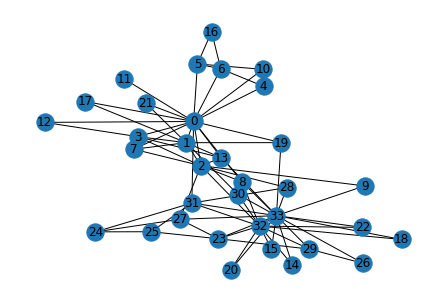

In [18]:
np.random.seed(0)
G = nx.karate_club_graph()
nx.draw(G, with_labels = True, pos=nx.spring_layout(G))

In [19]:
len(G.nodes), len(G.edges) # 34 nodes and 78 edges

(34, 78)

In [20]:
# parameters for this part.
# Do not modify this. There is a -5 point penalty if you modify this block of code. 

p=1 # Return parameter

q=1 # In-out parameter

walks=10 # Walks per node

length=80 # Length of each walk

d=16 # Dimension of output embeddings

window=10 # Window size for word2vec

workers=2 # Number of workers to assign for random walk and word2vec
    
directed='directed' # Specify if graph is directed. Default is undirected

# Give dictionary of node positions to plot in the graph

In [21]:
def community_detection(G):
  """
  Input: 
  G: nx.graph

  Steps to follow: 
  1. Generate embeddings for nodes in graph G using node2vec. 
  2. Transform node embeddings to an array using np.asarray. This will give a matrix where each row is a node embedding array.
  3. Call the kmeans function us?ing this matrix as input. 
  4. Use kmeans.predict to assign nodes to clusters. This will generate an array. Return this array. 

  Return:
  labels: array with each item corresponding to the label of each node. 
  
  """
  np.random.seed(0)
  kmeans = KMeans(n_clusters=2) # 2 communities -> 2 clusters
  probs = defaultdict(dict)
  for node in G.nodes():
    probs[node] = dict()

  ## write your code below [1 points]##

  transition_probs = compute_transition_probs(G, {}, p, q)
  walk = generate_walks(G, transition_probs, walks, length)
  model, embeddings = generate_embeddings(walk, d, window, workers, p, q)

  embed_matrix = np.asarray([embeddings[str(node_id)] for node_id in G.nodes()])

  labels = kmeans.fit_predict(embed_matrix)

  #######################################
  return labels

In [22]:
# Call the community_detection function. 
labels=community_detection(G)
Counter(labels)
# Note that all the nodes should be in at least one community, meaning that the sum of nodes in different communities, 
# should be equal to the total number of nodes in the graph

/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Counter({0: 16, 1: 18})

In [23]:
# This is for sanity check. The output should be True if your code is correct. 
current_sum = []

def check(labels):
  d=Counter(labels)
  for value in list(d.values()):
    current_sum.append(value)
  return sum(current_sum)

sum_of_nodes = check(labels)
if sum_of_nodes == len(G.nodes):
    print(True, sum_of_nodes, current_sum[0]/current_sum[1])
else:
    print(False, sum_of_nodes, current_sum[0]/current_sum[1])

True 34 0.8888888888888888


### Part 2.2 Plot the graph to show communities.

In [24]:
def plot_community(G, labels):
  """
  Plot the graph with labels in blue and red. 

  Input:
  G: nx.graph
  labels: Array with each item corresponding to the label of each node.

  Return:
  none

  Steps to follow:
  1. Create color_map as an empty list. Initialize iters as 0.
  2. For each node in G, check label of that node, if labels[iters]==0, set color to 'blue' else 'red' ,then append color to color_map let iters+1 for the next node.
  3. Use nx.draw to draw the plot, set node_color=color_map, with_labels=True, pos=nx.spring_layout(G, seed=0)

  """
  ## write your code below [0.5 points]##
  color_map = []
  iters = 0
  for node in G.nodes():
    if labels[node] == 0:
      color = 'blue'
    else:
      color = 'red'
    color_map.append(color)

  nx.draw(G, node_color=color_map, with_labels = True, pos=nx.spring_layout(G, seed=0))



  ############################

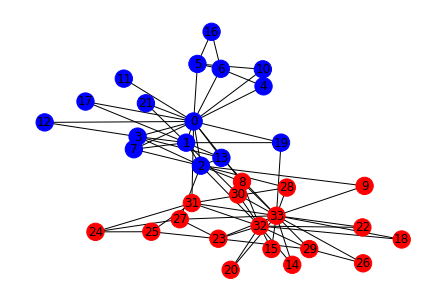

In [25]:
plot_community(G, labels)

# Part 3: Using embeddings for node classification [2 points]

Note: For this part, you will generate node embeddings from your functions in Part 1 and do a multi-label prediction. The idea comes from https://cs.stanford.edu/~jure/pubs/node2vec-kdd16.pdf. You should see similar results as shown in this paper.

In [26]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
from gensim.models import KeyedVectors
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score
from google.colab import files

import warnings
warnings.filterwarnings('ignore') 

In [27]:
# Parameters for this part. 
# Do not modify this. There is a -5 point penalty if you modify this block of code. 

input='blogcatalog.mat' # Path for input edgelist

p=0.25 # Return parameter

q=0.25 # In-out parameter

walks=10 # Walks per node

length=80 # Length of each walk

d=16 # Dimension of output embeddings

window=10 # Window size for word2vec

workers=4 # Number of workers to assign for random walk and word2vec

directed=True # Specify if graph is directed. Default is undirected

In [28]:
def sparse2array_inv_binarize(y):
    """
    Do not modify. This function transforms y. 
    """
    mlb = MultiLabelBinarizer(classes=np.arange(y.shape[1]))
    mlb.fit(y)
    y_ = mlb.inverse_transform(y.toarray())
    return y_

def custom_predict(classifier, X_test, y_test):
    """
    Do not modify. This function predicts using a given classifier. 
    """
    
    y_test_ = sparse2array_inv_binarize(y_test)
    num_predictions = [len(item) for item in y_test_]
    
    probabilities = classifier.predict_proba(X_test)
    sorted_indices_probs = probabilities.argsort()
    
    preds = [sorted_indices[-num:].tolist() for (sorted_indices,num) in zip(sorted_indices_probs,num_predictions)]
    
    return preds

def compute_metrics(y_test, preds):
    """
    compute microf1 and macrof1 based on y_test and preds, 
    for more information please refer to https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html

    Input:
    y_test: Ground truth
    preds: Output of custom_predict function

    Output:
    microF1: Array of micro f1 scores.
    macroF1: Array of macro f1 scores.

    Steps to follow:
    1. Call f1_score to calculate micro f1 score. 
    2. Call f1_score to calculate macro f1 score. 

    """
    
    mlb = MultiLabelBinarizer(classes=np.arange(y_test.shape[1]))
    mlb.fit(preds)
    preds = mlb.transform(preds)

    y_test = sparse2array_inv_binarize(y_test)
    y_test = mlb.transform(y_test)
    ## get your microF1 and macroF1 score here [0.4 points]##
    microF1 = f1_score(y_true=y_test, y_pred=preds, average='micro')
    macroF1 = f1_score(y_true=y_test, y_pred=preds, average='macro')
    #############################################
    return microF1, macroF1

def plot_graph(trainsize, res):
    """
    Do not modify. This function generates plots. 
    """
    micro, = plt.plot(trainsize, [a[0] for a in res], c='b', marker = 's', label='Micro F1')
    macro, = plt.plot(trainsize, [a[1] for a in res], c='r', marker = 'x', label='Macro F1')
    plt.legend(handles=[micro,macro])
    plt.grid(True)
    plt.xlabel('Training Size')
    plt.ylabel('F1 score')
    plt.show()
    
    return

def evaluate(G, labels, word_vec):
    """
    Input: 
    G: graph
    labels: labels for training 
    word_vec:  node embeddings in dictionary format. Generated from svd_embedding and Node2vec functions.  

    Return:
    all_results(dictionary with keys to be classifier name and values to be lists of scores [microF1, macroF1] under different training_set_size)

    Steps to follow in code block 1 below: 
    1. Transform node embeddings to an array using np.asarray. This will give a matrix where each row is a node embedding array.

    Steps to follow in code block 2 below: 
    1. Initialze results as a list.
    2. For every training size in training_set_size, use train_test_split to generate X_train, X_test, y_train, y_test, set random_state=42
    3. Fit X_train, y_train to the model
    4. Call custom_predict function and get predictions
    5. Call compute_metrics and get microF1 and macroF1
    6. Append [microF1,macroF1] to results

    """
    classifiers = {'Logistic_Regression': OneVsRestClassifier(LogisticRegression())}
    
    ## transform embedding to array [0.1 points]. This is code block 1. ##
    #embed_matrix = np.asarray([word_vec[str(i)] for i in range(len(G.nodes()))])
    embed_matrix = np.asarray([word_vec[str(i)] for i in sorted(list(G.nodes()))])
    ##############################################
    
    training_set_size = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    all_results = {}
    for (name,model) in classifiers.items():
      results = []
      for training_size in training_set_size:
        ## write your code below [0.6 points]. This is code block 2. ##        
        X_train, X_test, y_train, y_test = train_test_split(embed_matrix, labels, test_size=training_size, random_state=42)
        new_model = model.fit(X_train, y_train)
        preds = custom_predict(new_model, X_test, y_test)
        microF1, macroF1 = compute_metrics(y_test, preds)
        results.append([microF1, macroF1])
          #######################################
      all_results[name] = results
    return all_results

In [29]:
# Do not modify. 
# This cell will evaluate logistic regression classifer and get the plot of f1 scores

def eval_classifier(G, subs_coo, word_vec):
    print("\t**Evaluating classifier performance with the embeddings**")

    results = evaluate(G, subs_coo, word_vec)
    
    print("\n Evaluation completed using the following:")
    for i in results.keys():
        print("--> ",i)
    
    print("\nPrinting evaluation results : ")
    trainsize = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    for (name,res) in results.items():
        print("\n\nClassifier : ",name)
        for (tr_size,res_) in zip(trainsize,res):
            print("\tTraining size : ",tr_size)
            print("\t\tMicro F1: ",res_[0])
            print("\t\tMacro F1: ",res_[1])
        
        avg = np.average(res,axis=0)
        print("\t---------------------------------------")
        print("\t Average Micro F1 : ",avg[0])
        print("\t Average Macro F1 : ",avg[1])
        plot_graph(trainsize, res)

In [30]:
# Generate SVD embedding of nodes 
# read graph
G, labels, init_probabilities = read_graph(input, directed)
# generate SVD embedding 
svd_embeddings=SVD_embedding(G, d) 

	**Evaluating classifier performance with the embeddings**

 Evaluation completed using the following:
-->  Logistic_Regression

Printing evaluation results : 


Classifier :  Logistic_Regression
	Training size :  0.1
		Micro F1:  0.17788802267895112
		Macro F1:  0.02843349015501813
	Training size :  0.2
		Micro F1:  0.1705697308633345
		Macro F1:  0.029824669726548264
	Training size :  0.3
		Micro F1:  0.16321303841676368
		Macro F1:  0.02740782531541114
	Training size :  0.4
		Micro F1:  0.16262135922330098
		Macro F1:  0.028185648221156663
	Training size :  0.5
		Micro F1:  0.162993762993763
		Macro F1:  0.029212308384884273
	Training size :  0.6
		Micro F1:  0.16330296390266405
		Macro F1:  0.03010870637729381
	Training size :  0.7
		Micro F1:  0.16409342834520982
		Macro F1:  0.02952410199690702
	Training size :  0.8
		Micro F1:  0.16528425781925005
		Macro F1:  0.031031191577344297
	Training size :  0.9
		Micro F1:  0.16524871617996476
		Macro F1:  0.03053571174446857
	----------

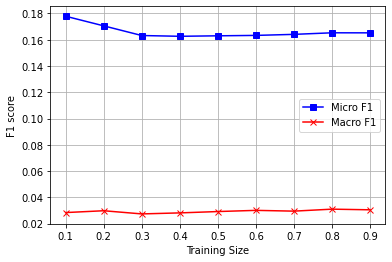

In [31]:
# Plot the classifier performance when trained using SVD embeddings
eval_classifier(G, labels, svd_embeddings)

In [32]:
# Load the pre-trained embeddings generated via node2vec for embedding size d=16: pretrained_node2vec_embeddings_16.emb. 
# We are providing the pre-trained embedding since generating the embeddings takes over an hour. 
# So, we generated the embeddings using the same functions in Part 1 and are providing it to you. 
# You don't have to run the code again to generate the embeddings and can use the pretrained embeddings directly by running this cell. 

node2vec_emb = KeyedVectors.load_word2vec_format('pretrained_node2vec_embeddings_16.emb')

	**Evaluating classifier performance with the embeddings**

 Evaluation completed using the following:
-->  Logistic_Regression

Printing evaluation results : 


Classifier :  Logistic_Regression
	Training size :  0.1
		Micro F1:  0.37987243090007095
		Macro F1:  0.19265795504669575
	Training size :  0.2
		Micro F1:  0.3649073750436911
		Macro F1:  0.18708540501203033
	Training size :  0.3
		Micro F1:  0.3627473806752037
		Macro F1:  0.18649088836664854
	Training size :  0.4
		Micro F1:  0.36355755894590847
		Macro F1:  0.18639523057845425
	Training size :  0.5
		Micro F1:  0.36077616077616076
		Macro F1:  0.18466904681857746
	Training size :  0.6
		Micro F1:  0.3593587821473879
		Macro F1:  0.18119684749117995
	Training size :  0.7
		Micro F1:  0.35906571654790176
		Macro F1:  0.17966038370036197
	Training size :  0.8
		Micro F1:  0.35813029203386904
		Macro F1:  0.17938673795980473
	Training size :  0.9
		Micro F1:  0.3468996704223193
		Macro F1:  0.17139793349605487
	---------------

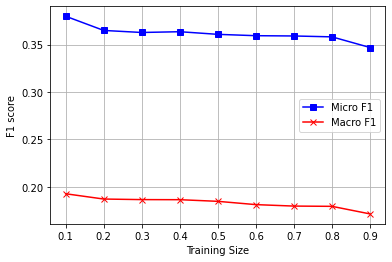

In [33]:
# Plot the classifier performance when trained using node2vec embeddings
eval_classifier(G, labels, node2vec_emb)

In [34]:
# Now, load the pretrained embeddings generated via node2vec with d = 128: pretrained_node2vec_embeddings_128.emb. 
# The goal is to generate the plot with a same method, but by varying the value of d. 
# We are providing the pre-trained embedding since generating the embeddings takes several hours.
# So, we generated the embeddings using the same functions in Part 1 and are providing it to you. 
# You don't have to run the code again to generate the embeddings and can use the pretrained embeddings directly by running this cell. 

node2vec_emb = KeyedVectors.load_word2vec_format('pretrained_node2vec_embeddings_128.emb')

	**Evaluating classifier performance with the embeddings**

 Evaluation completed using the following:
-->  Logistic_Regression

Printing evaluation results : 


Classifier :  Logistic_Regression
	Training size :  0.1
		Micro F1:  0.4145995747696669
		Macro F1:  0.2952550742831733
	Training size :  0.2
		Micro F1:  0.4138413142257952
		Macro F1:  0.2952934936806025
	Training size :  0.3
		Micro F1:  0.41047729918509895
		Macro F1:  0.28826471994007125
	Training size :  0.4
		Micro F1:  0.4119278779472954
		Macro F1:  0.29106025884779474
	Training size :  0.5
		Micro F1:  0.3997227997227997
		Macro F1:  0.2739118178852345
	Training size :  0.6
		Micro F1:  0.39338023296044283
		Macro F1:  0.2703476521894938
	Training size :  0.7
		Micro F1:  0.38717339667458434
		Macro F1:  0.25539072686385245
	Training size :  0.8
		Micro F1:  0.36815275617763954
		Macro F1:  0.2352865940121189
	Training size :  0.9
		Micro F1:  0.3430673718096114
		Macro F1:  0.20423028753679837
	---------------------

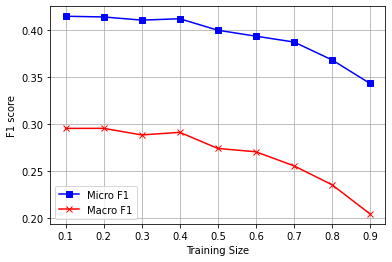

In [35]:
# Plot the classifier performance when trained using node2vec embeddings
eval_classifier(G, labels, node2vec_emb)

## Answer these questions below: 

(Q1) Report the performance of SVD(d=16) and node2vec(d=16) in terms of average micro F1 and average macro F1. Which is better? [0.3 points]


> For the SVD embeddings, the average Micro F1 score was 0.166 and the Macro F1 score was 0.029. For the Node2Vec embeddings, the average Micro F1 score was 0.362 and the average Macro F1 score was 0.183. Since a higher F1 score means a higher precision and recall, Node2Ved had a much better performance for 16 dimensional embeddings.


(Q2) If node2vec performs better than SVD, give **two** reasons why. Alternatively, if SVD performs better than node2vec, give **two** reasons why [0.3 points]


> 1. Node2Vec performs better than SVD because it is more robust to potential variability and noise in the data, since it takes into account multiple random walks when generating the embeddings instead of simply factorizing a matrix.
> 2. Additionally, Node2Vec captures more complicated relationships between the nodes and general graph structure, whereas SVD embeddings are only able to capture linear, surface level characteristics of each node.


(Q3) What is the effect of changing the dimensionality of the **node2vec** embeddings on the prediction task? 

In this part, compare the model performance on the node classification task of **_d = 16_** versus **_d = 128_**. These are the two plots you generated using the pretrained embeddings. 

In your answer, report **Average Micro F1** and **Average Macro F1 scores** and their **performace** when measured with respect to F1 scores as training size increases. Compare the values. Which dimension size performs better? [0.3 points]. 


> As training size increases, the F1 scores generally decrease, but this was much more apparent for Node2Vec when d=128. For d = 16, and the average Micro F1 score was 0.362 and the Macro F1 score was 0.183, whereas for d = 128, the average Micro F1 Score was 0.394 and the Macro F1 score was 0.268.